In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
K.set_image_dim_ordering('th')

In [4]:
# Seeding 
np.random.seed(1000)

In [5]:
# Dimensionality of the random vector.
randomDim = 10

In [6]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [7]:
# Define optimizer.
adam = Adam(lr=0.002, beta_1=0.5)

In [13]:
#Generator

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [18]:
# Discriminator

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))

# Scenario 1 - train discriminator with original inputs
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [19]:
# Scenario 2 - train generator using the randomly generated inputs.
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [20]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()


In [44]:
# Training method

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %f' % e, '-'*15)
        for i in range(int(batchCount)):
            # Get a random set of input noise and images.
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0],size=batchSize)]
            
            # Generate fake MNIST images.
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])
            
            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            yDis[:batchSize] = 0.9
            
            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
            # Train geneator
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            
            if i == 0 or i % 20 == 0:
                print('.', end=" ")
            
        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
        else:
            print(" ")
        

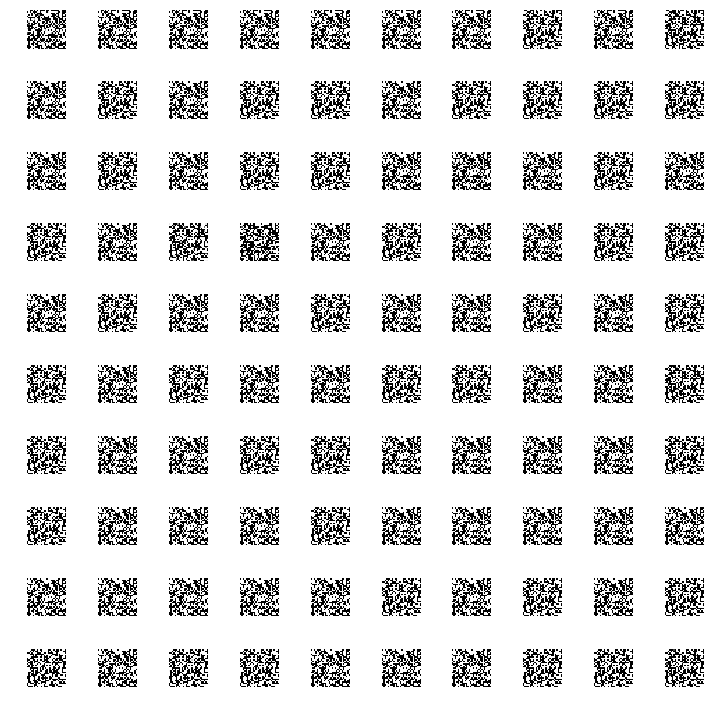

In [46]:
plotGeneratedImages(1)

In [45]:
train(200, 128)

Epochs: 200
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . . --------------- Epoch 2.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 3.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 4.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 5.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 6.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 7.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 8.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 9.000000 ---------------
. . . . . . . . . . . . . . . . . . . . . . . .  
--------------- Epoch 10.000000 ---------------
. . . . . . . . . . . . . .

KeyboardInterrupt: 